In [ ]:
!pip install yfinance tensorflow numpy pandas matplotlib scikit-learn

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Download Apple (AAPL) stock data
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-12-31"

data = yf.download(ticker, start=start_date, end=end_date)
stock_prices = data['Close'].values.reshape(-1, 1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Normalize data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_prices)

# Create time-series dataset
look_back = 60  # Use last 60 days to predict next day
X, y = [], []

for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape for LSTM [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into Train & Test (80% Train, 20% Test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 6.0287e-04 - val_loss: 0.0042
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 6.2148e-04 - val_loss: 0.0022
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 6.2568e-04 - val_loss: 0.0044
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 5.1123e-04 - val_loss: 0.0072
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 4.6730e-04 - val_loss: 0.0012
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 4.0115e-04 - val_loss: 0.0015
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 4.3182e-04 - val_loss: 0.0050
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 4.2763e-04 - val_loss: 0.0020
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 4.0014e-04 - val_loss: 0.0015
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 4.1324e-04 - val_loss: 0.0018
Epoch 12/5

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


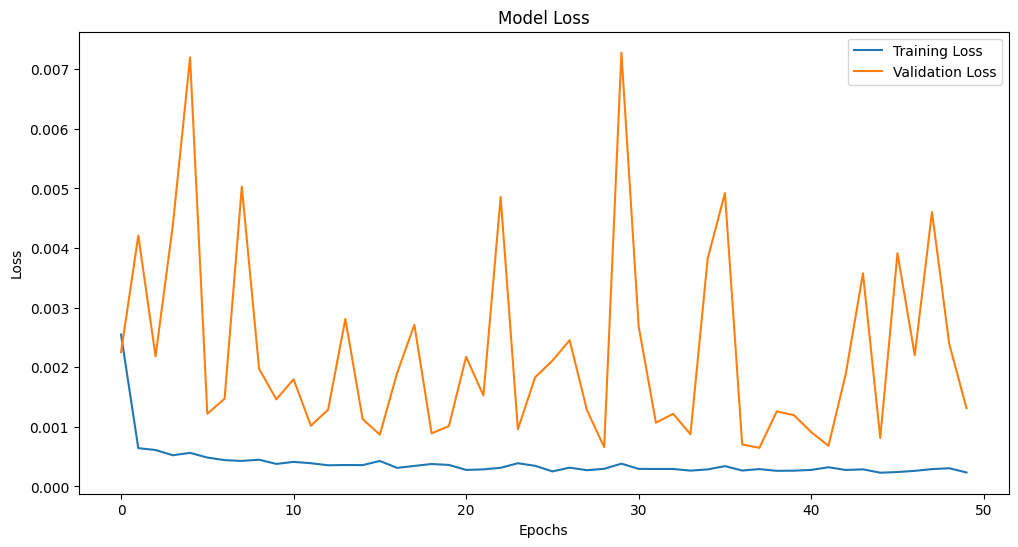

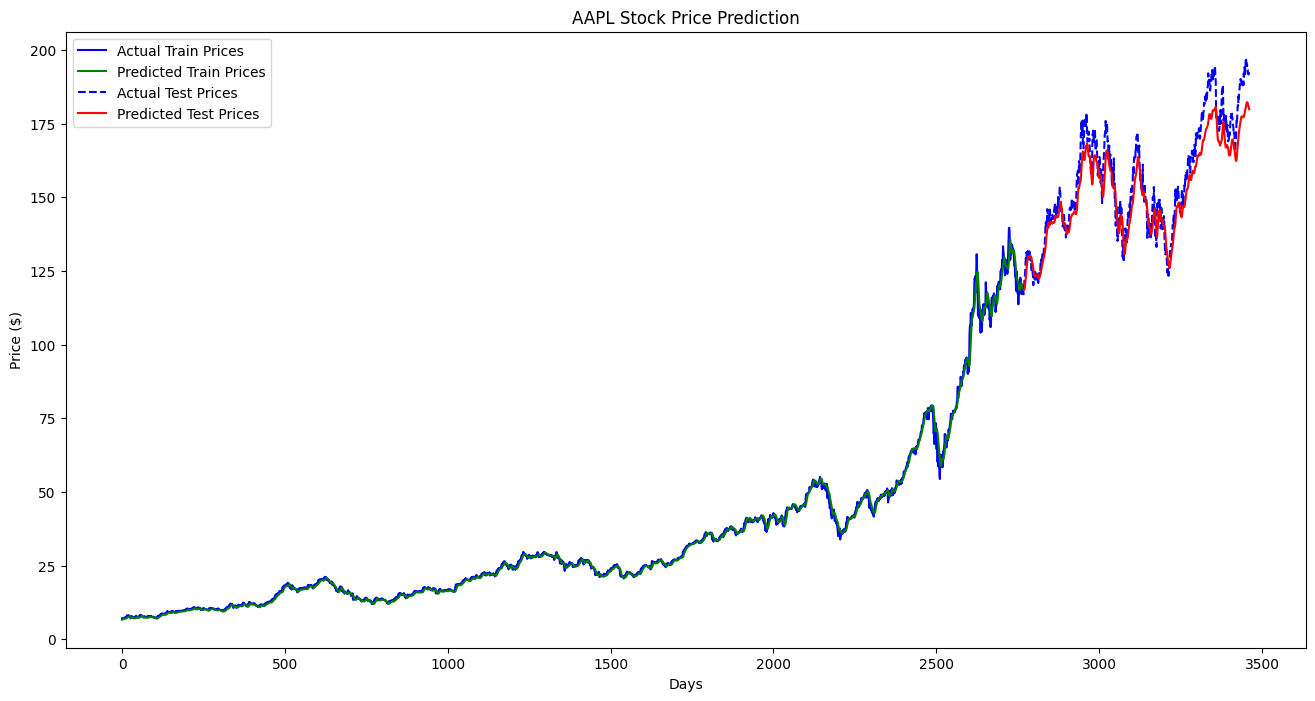

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted prices
plt.figure(figsize=(16, 8))
plt.plot(y_train_actual, label='Actual Train Prices', color='blue')
plt.plot(train_predict, label='Predicted Train Prices', color='green')
plt.plot(range(len(y_train_actual), len(y_train_actual)+len(y_test_actual)), y_test_actual, label='Actual Test Prices', color='blue', linestyle='dashed')
plt.plot(range(len(train_predict), len(train_predict)+len(test_predict)), test_predict, label='Predicted Test Prices', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

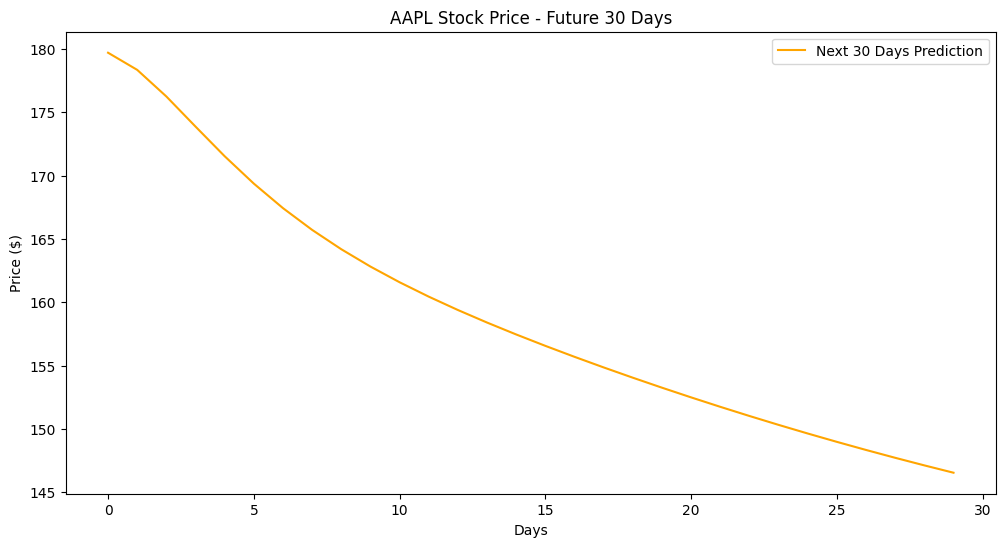

In [ ]:
# Predict next 30 days
last_60_days = scaled_data[-look_back:]
future_predictions = []

for _ in range(30):
    next_pred = model.predict(last_60_days.reshape(1, look_back, 1))
    future_predictions.append(next_pred[0, 0])
    last_60_days = np.append(last_60_days[1:], next_pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_predictions, label='Next 30 Days Prediction', color='orange')
plt.title(f'{ticker} Stock Price - Future 30 Days')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()